In [6]:
import itertools
import math
import hoomd
import os

import freud
import gsd.hoomd
import matplotlib
import numpy

# %matplotlib inline
# matplotlib.style.use('ggplot')
import matplotlib_inline

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# fn = os.path.join(os.getcwd(), 'random.gsd')
# ![ -e "$fn" ] && rm "$fn"

import io
import warnings

import fresnel
import IPython
import numpy as np
import packaging.version
import PIL

device = fresnel.Device()
tracer = fresnel.tracer.Path(device=device, w=300, h=300)

FRESNEL_MIN_VERSION = packaging.version.parse('0.13.0')
FRESNEL_MAX_VERSION = packaging.version.parse('0.14.0')

def render_initial(position, orientation, L, vertices, one_shape=True):
    if (
        'version' not in dir(fresnel)
        or packaging.version.parse(fresnel.version.version) < FRESNEL_MIN_VERSION
        or packaging.version.parse(fresnel.version.version) >= FRESNEL_MAX_VERSION
    ):
        warnings.warn(
            f'Unsupported fresnel version {fresnel.version.version} - expect errors.'
        )

    if one_shape==False:
        poly_info1 = fresnel.util.convex_polyhedron_from_vertices(vertices[0])
        poly_info2 = fresnel.util.convex_polyhedron_from_vertices(vertices[1])

        scene = fresnel.Scene(device)
        geometry1 = fresnel.geometry.ConvexPolyhedron(scene, poly_info1, N=len(position[0]))
        geometry1.material = fresnel.material.Material(
            color=fresnel.color.linear([0.01, 0.74, 0.26]), roughness=0.5
        )
        geometry1.position[:] = position[0][:]
        geometry1.orientation[:] = orientation[0][:]
        geometry1.outline_width = 0.01

        geometry2 = fresnel.geometry.ConvexPolyhedron(scene, poly_info2, N=len(position[1]))
        geometry2.material = fresnel.material.Material(
            color=fresnel.color.linear([0.01, 0.34, 0.66]), roughness=0.5
        )
        geometry2.position[:] = position[1][:]
        geometry2.orientation[:] = orientation[1][:]
        geometry2.outline_width = 0.01
    else:

        poly_info = fresnel.util.convex_polyhedron_from_vertices(vertices)

        scene = fresnel.Scene(device)
        geometry = fresnel.geometry.ConvexPolyhedron(scene, poly_info, N=len(position))
        geometry.material = fresnel.material.Material(
            color=fresnel.color.linear([0.01, 0.74, 0.26]), roughness=0.5
        )
        geometry.position[:] = position[:]
        geometry.orientation[:] = orientation[:]
        geometry.outline_width = 0.01

    fresnel.geometry.Box(scene, [L, L, L, 0, 0, 0], box_radius=0.02)

    scene.lights = [
        fresnel.light.Light(direction=(0, 0, 1), color=(0.8, 0.8, 0.8), theta=math.pi),
        fresnel.light.Light(
            direction=(1, 1, 1), color=(1.1, 1.1, 1.1), theta=math.pi / 3
        ),
    ]
    scene.camera = fresnel.camera.Orthographic(
        position=(L * 2, L, L * 2), look_at=(0, 0, 0), up=(0, 1, 0), height=L * 1.4 + 1
    )
    scene.background_color = (1, 1, 1)
    scene.background_alpha = 1
    return IPython.display.Image(tracer.sample(scene, samples=500)._repr_png_())

def render(snapshot, vertices, one_shape=True):
    if (
        'version' not in dir(fresnel)
        or packaging.version.parse(fresnel.version.version) < FRESNEL_MIN_VERSION
        or packaging.version.parse(fresnel.version.version) >= FRESNEL_MAX_VERSION
    ):
        warnings.warn(
            f'Unsupported fresnel version {fresnel.version.version} - expect errors.'
        )
    L = snapshot.configuration.box[0]
    # vertices = [
    #     (-0.5, 0, 0),
    #     (0.5, 0, 0),
    #     (0, -0.5, 0),
    #     (0, 0.5, 0),
    #     (0, 0, -0.5),
    #     (0, 0, 0.5),
    # ]
    if one_shape == False:
        #booleans
        type1 = snapshot.particles.typeid == 0
        type2 = snapshot.particles.typeid == 1

        poly_info1 = fresnel.util.convex_polyhedron_from_vertices(vertices[0])
        poly_info2 = fresnel.util.convex_polyhedron_from_vertices(vertices[1])

        scene = fresnel.Scene(device)
        geometry1 = fresnel.geometry.ConvexPolyhedron(
            scene, poly_info1, N=len(snapshot.particles.position[type1])
        )
        geometry1.material = fresnel.material.Material(
            color=fresnel.color.linear([0.01, 0.74, 0.26]), roughness=0.5
        )
        geometry1.position[:] = snapshot.particles.position[type1]
        geometry1.orientation[:] = snapshot.particles.orientation[type1]
        geometry1.outline_width = 0.01

        geometry2 = fresnel.geometry.ConvexPolyhedron(
            scene, poly_info2, N=len(snapshot.particles.position[type2])
        )
        geometry2.material = fresnel.material.Material(
            color=fresnel.color.linear([0.01, 0.34, 0.66]), roughness=0.5
        )
        geometry2.position[:] = snapshot.particles.position[type2]
        geometry2.orientation[:] = snapshot.particles.orientation[type2]
        geometry2.outline_width = 0.01

    else:
        poly_info = fresnel.util.convex_polyhedron_from_vertices(vertices)

        scene = fresnel.Scene(device)
        geometry = fresnel.geometry.ConvexPolyhedron(
            scene, poly_info, N=snapshot.particles.N
        )
        geometry.material = fresnel.material.Material(
            color=fresnel.color.linear([0.01, 0.74, 0.26]), roughness=0.5
        )
        geometry.position[:] = snapshot.particles.position[:]
        geometry.orientation[:] = snapshot.particles.orientation[:]
        geometry.outline_width = 0.01

    fresnel.geometry.Box(scene, snapshot.configuration.box, box_radius=0.02)

    scene.lights = [
        fresnel.light.Light(direction=(0, 0, 1), color=(0.8, 0.8, 0.8), theta=math.pi),
        fresnel.light.Light(
            direction=(1, 1, 1), color=(1.1, 1.1, 1.1), theta=math.pi / 3
        ),
    ]
    scene.camera = fresnel.camera.Orthographic(
        position=(L * 2, L, L * 2), look_at=(0, 0, 0), up=(0, 1, 0), height=L * 1.4 + 1
    )
    scene.background_alpha = 1
    scene.background_color = (1, 1, 1)
    return IPython.display.Image(tracer.sample(scene, samples=500)._repr_png_())

def render_traj(snapshot, vertices, particles=None, is_solid=None):
    if (
        'version' not in dir(fresnel)
        or packaging.version.parse(fresnel.version.version) < FRESNEL_MIN_VERSION
        or packaging.version.parse(fresnel.version.version) >= FRESNEL_MAX_VERSION
    ):
        warnings.warn(
            f'Unsupported fresnel version {fresnel.version.version} - expect errors.'
        )

    poly_info = fresnel.util.convex_polyhedron_from_vertices(vertices)
    N = snapshot.particles.N
    L = snapshot.configuration.box[0]
    if particles is not None:
        N = len(particles)
    if is_solid is not None:
        N = int(numpy.sum(is_solid))

    scene = fresnel.Scene(device)
    geometry = fresnel.geometry.ConvexPolyhedron(scene, poly_info, N=N)
    geometry.material = fresnel.material.Material(
        color=fresnel.color.linear([0.01, 0.74, 0.26]), roughness=0.5
    )
    if particles is None and is_solid is None:
        geometry.position[:] = snapshot.particles.position[:]
        geometry.orientation[:] = snapshot.particles.orientation[:]
    elif particles is not None:
        geometry.position[:] = snapshot.particles.position[particles, :]
        geometry.orientation[:] = snapshot.particles.orientation[particles, :]
    elif is_solid is not None:
        geometry.position[:] = snapshot.particles.position[
            numpy.ix_(is_solid, [0, 1, 2])
        ]
        geometry.orientation[:] = snapshot.particles.orientation[
            numpy.ix_(is_solid, [0, 1, 2, 3])
        ]

    geometry.outline_width = 0.01
    fresnel.geometry.Box(scene, snapshot.configuration.box, box_radius=0.02)

    scene.lights = [
        fresnel.light.Light(direction=(0, 0, 1), color=(0.8, 0.8, 0.8), theta=math.pi),
        fresnel.light.Light(
            direction=(1, 1, 1), color=(1.1, 1.1, 1.1), theta=math.pi / 3
        ),
    ]
    scene.camera = fresnel.camera.Orthographic(
        position=(L * 2, L, L * 2), look_at=(0, 0, 0), up=(0, 1, 0), height=L * 1.4 + 1
    )
    scene.background_color = (1, 1, 1)
    return tracer.sample(scene, samples=500)

def render_movie(frames, vertices, particles=None, is_solid=None):
    if is_solid is None:
        is_solid = [None] * len(frames)
    a = render_traj(frames[0], vertices, particles, is_solid[0])

    im0 = PIL.Image.fromarray(a[:, :, 0:3], mode='RGB').convert(
        'P', palette=PIL.Image.Palette.ADAPTIVE
    )
    ims = []
    for i, f in enumerate(frames[1:]):
        a = render_traj(f,vertices, particles, is_solid[i])
        im = PIL.Image.fromarray(a[:, :, 0:3], mode='RGB')
        im_p = im.quantize(palette=im0)
        ims.append(im_p)

    blank = np.ones(shape=(im.height, im.width, 3), dtype=np.uint8) * 255
    im = PIL.Image.fromarray(blank, mode='RGB')
    im_p = im.quantize(palette=im0)
    ims.append(im_p)

    f = io.BytesIO()
    im0.save(f, 'gif', save_all=True, append_images=ims, duration=1000, loop=0)

    size = len(f.getbuffer()) / 1024
    if size > 3000:
        warnings.warn(f'Large GIF: {size} KiB')
    return IPython.display.display(IPython.display.Image(data=f.getvalue()))

tetra_vertices = [
    (0, 0, 0.5),
    (0, 0.7071, -0.5),
    (0.5*np.sqrt(3/2), -0.3535, -0.5),
    (-0.5*np.sqrt(3/2), -0.3535, -0.5),
]

cube_vertices = [
    (0.5, 0.5, 0.5),
    (-0.5, 0.5, 0.5),
    (-0.5, -0.5, 0.5),
    (-0.5, 0.5, -0.5),
    (0.5, -0.5, 0.5),
    (0.5, -0.5, -0.5),
    (0.5, 0.5, -0.5),
    (-0.5, -0.5, -0.5),
]

# cube_vertices = list(np.array(cube_vertices)*0.5)

octahedron_vertices = [
    (-0.35355339,  0,          0        ),
    (0.35355339,  0,          0.        ),
    (0,         -0.35355339,  0        ),
    (0,          0.35355339,  0        ),
    (0,          0,         -0.35355339),
    (0,          0,          0.35355339),
]
    # (-0.5, 0, 0),
    # (0.5, 0, 0),
    # (0, -0.5, 0),
    # (0, 0.5, 0),
    # (0, 0, -0.5),
    # (0, 0, 0.5),


#Integrator
mc = hoomd.hpmc.integrate.ConvexPolyhedron()
mc.shape['cube'] = dict(vertices=cube_vertices)
mc.shape['octahedron'] = dict(vertices=octahedron_vertices)

mc.nselect = 2
mc.d['cube'] = 0.15
mc.a['cube'] = 0.2

#Initial State
m = 4
N_particles = 2*m**3

ratio = 0.667#0.75
N_cube = int(N_particles*ratio)
N_octa = N_particles-N_cube

spacing = 1.5
K = math.ceil(N_particles**(1/3))
L = K*spacing

x = np.linspace(-L/2, L/2, K, endpoint=False)
position_cube = list(itertools.product(x, repeat=3))
position_octa = list(itertools.product(x, repeat=3))

position_cube = position_cube[0:N_cube]
position_octa = position_octa[N_cube:N_particles]

positions = position_cube + position_octa

orientation_cube = [(1,0,0,0)] * N_cube
orientation_octa = [(1,0,0,0)] * N_octa
orientation = orientation_cube + orientation_octa

frame = gsd.hoomd.Frame()
frame.particles.N = N_particles
frame.particles.position = positions
frame.particles.orientation = orientation
frame.particles.typeid = [0] * N_cube + [1] * N_octa
frame.particles.types = ['cube', 'octahedron']
frame.configuration.box = [L,L,L,0,0,0]

cpu = hoomd.device.CPU()

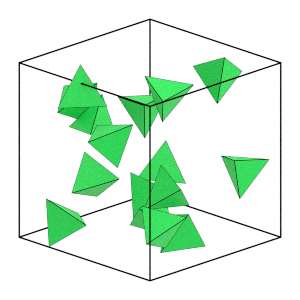

In [8]:
#render gsd file
traj = gsd.hoomd.open('tetra_test.gsd')
render_movie(traj[0:100:12], tetra_vertices)

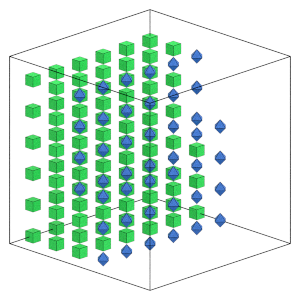

In [26]:


with gsd.hoomd.open(name='lattice2.gsd', mode='x') as f:
    f.append(frame)

render_initial([position_cube, position_octa], [orientation_cube, orientation_octa], L, [cube_vertices, octahedron_vertices], one_shape=False)

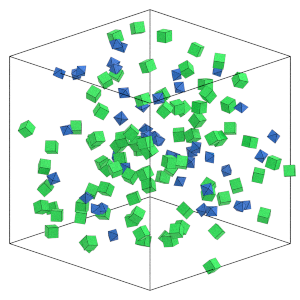

In [27]:
#Randomizing
simulation_rand = hoomd.Simulation(device=cpu, seed=9)
simulation_rand.operations.integrator = mc
simulation_rand.create_state_from_gsd(filename='lattice2.gsd')

initial_snapshot = simulation_rand.state.get_snapshot()
simulation_rand.run(10e3)
final_snapshot = simulation_rand.state.get_snapshot()

hoomd.write.GSD.write(state=simulation_rand.state, mode='xb', filename='random2.gsd')
render(final_snapshot, [cube_vertices, octahedron_vertices], one_shape=False)

In [28]:
mc.overlaps

0

0.018050479148493545
14000


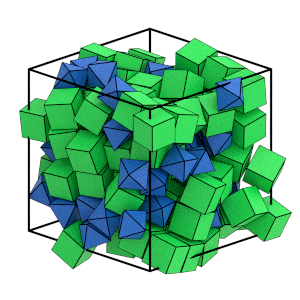

In [33]:
simulation_comp = hoomd.Simulation(device=cpu, seed=9)
simulation_comp.operations.integrator = mc
simulation_comp.create_state_from_gsd(filename='random2.gsd')

V_particle_cube = 0.5**3
V_particle_octa = 1/3 * np.sqrt(2) * (0.5)**3
initial_volume_fraction = ((N_cube * V_particle_cube + N_octa * V_particle_octa) / simulation_comp.state.box.volume)
print(initial_volume_fraction)

initial_box = simulation_comp.state.box
final_box = hoomd.Box.from_box(initial_box)
final_volume_fraction = 0.57
final_box.volume = (N_cube * V_particle_cube + N_octa * V_particle_octa)/ final_volume_fraction
compress = hoomd.hpmc.update.QuickCompress(trigger=hoomd.trigger.Periodic(10), target_box=final_box)
simulation_comp.operations.updaters.append(compress)

periodic = hoomd.trigger.Periodic(10)
tune = hoomd.hpmc.tune.MoveSize.scale_solver(moves=['a','d'], target=0.2, trigger=periodic, max_translation_move=0.2, max_rotation_move=0.2)
simulation_comp.operations.tuners.append(tune)

while not compress.complete and simulation_comp.timestep < 1e6:
    simulation_comp.run(1000)
print(simulation_comp.timestep)

if not compress.complete:
    print('uhhhhhh')



render(simulation_comp.state.get_snapshot(), [cube_vertices, octahedron_vertices], one_shape=False)

In [34]:
hoomd.write.GSD.write(state=simulation_comp.state, mode='xb', filename='compressed2.gsd')

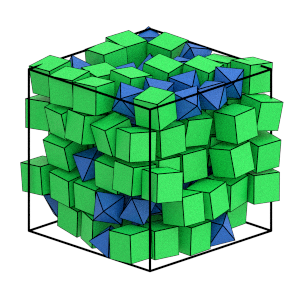

In [36]:
simulation = hoomd.Simulation(device=cpu, seed=9)
simulation.operations.integrator = mc
simulation.create_state_from_gsd(filename='compressed2.gsd')

# gsd_writer = hoomd.write.GSD(filename='trajectory2.gsd', trigger=hoomd.trigger.Periodic(1000), mode='xb')
# simulation.operations.writers.append(gsd_writer)

tune2 = hoomd.hpmc.tune.MoveSize.scale_solver(moves=['a','d'], target=0.2, trigger=hoomd.trigger.And([hoomd.trigger.Periodic(100), hoomd.trigger.Before(simulation.timestep + 5000)]))
simulation.operations.tuners.append(tune2)
simulation.run(5000)

simulation.run(100)

simulation.run(1e6)
render(simulation.state.get_snapshot(), [cube_vertices, octahedron_vertices], one_shape=False)

In [1]:
simulation.run(1e6)
render(simulation.state.get_snapshot(), [cube_vertices, octahedron_vertices], one_shape=False)

NameError: name 'simulation' is not defined

In [26]:
gsd_writer.flush()

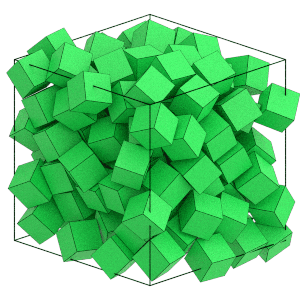

In [6]:
traj = gsd.hoomd.open('trajectory.gsd')
render_movie(traj[0:100:12], cube_vertices)

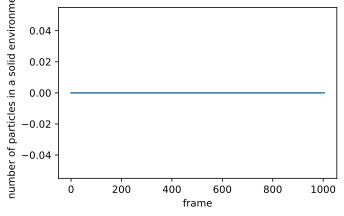

In [10]:
solid = freud.order.SolidLiquid(l=6, q_threshold=0.7, solid_threshold=6)
is_solid = []
for frame in traj:
    solid.compute(system=(frame.configuration.box, frame.particles.position), neighbors=dict(mode='nearest', num_neighbors=6))
    is_solid.append(solid.num_connections > solid.solid_threshold)

fig = matplotlib.figure.Figure(figsize=(5, 3.09))
ax = fig.add_subplot()
num_solid = np.array([np.sum(a) for a in is_solid])
ax.plot(num_solid)
ax.set_xlabel('frame')
ax.set_ylabel('number of particles in a solid environment')
fig

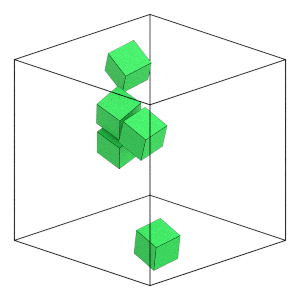

In [49]:
start_frame = int(np.argmax(num_solid > 4))
end_frame = int(np.argmax(num_solid == np.max(num_solid)))
step = int((end_frame - start_frame) / 6)
render_movie(traj[start_frame:end_frame:step], cube_vertices, is_solid=is_solid[start_frame:end_frame:step])